In [50]:
# Import the required modules
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets as dta
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder


### DATA EXPLORATION

In [51]:
# Read in the app-data.csv file into a Pandas Dataframe 
consumer_data_df = pd.read_csv('customer_purchase_data.csv')

# Review the DataFrame
consumer_data_df.head()

,Customer_ID,Age,Gender,Category,Category_ID,Item_Purchased,Item_Purchased_ID,Purchase_Amount (USD),Location,Size,Color,Sku_ID,Season,Review_Rating,Subscription Status,Shipping_Type,Discount_Applied,Previous_Purchases,Frequency of Purchases
0,1,55,Male,Clothing,Clo_M_01,Blouse,Clo_M_Blouse,53,Kentucky,L,Gray,SKU_01,Winter,3.1,Yes,Express,Yes,14,Fortnightly
1,2,19,Male,Clothing,Clo_M_01,Sweater,Clo_M_Sweater,64,Maine,L,Maroon,SKU_02,Winter,3.1,Yes,Express,Yes,2,Fortnightly
2,3,50,Male,Clothing,Clo_M_01,Jeans,Clo_M_Jeans,73,Massachusetts,S,Maroon,SKU_03,Spring,3.1,Yes,Free Shipping,Yes,23,Weekly
3,4,21,Male,Footwear,Footw_M_01,Sandals,Footw_M_Sandals,90,Rhode Island,M,Maroon,SKU_04,Spring,3.5,Yes,Next Day Air,Yes,49,Weekly
4,5,45,Male,Clothing,Clo_M_01,Blouse,Clo_M_Blouse,49,Oregon,M,Turquoise,SKU_05,Spring,2.7,Yes,Free Shipping,Yes,31,Annually


In [52]:
# Check for null values and the data types.
consumer_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2445 entries, 0 to 2444
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer_ID             2445 non-null   int64  
 1   Age                     2445 non-null   int64  
 2   Gender                  2445 non-null   object 
 3   Category                2445 non-null   object 
 4   Category_ID             2445 non-null   object 
 5   Item_Purchased          2445 non-null   object 
 6   Item_Purchased_ID       2445 non-null   object 
 7   Purchase_Amount (USD)   2445 non-null   int64  
 8   Location                2445 non-null   object 
 9   Size                    2445 non-null   object 
 10  Color                   2445 non-null   object 
 11  Sku_ID                  2445 non-null   object 
 12  Season                  2445 non-null   object 
 13  Review_Rating           2445 non-null   float64
 14  Subscription Status     2445 non-null   

In [53]:
# Drop rows with null values
df_clean = consumer_data_df.dropna().copy()
consumer_df = df_clean.copy()

In [54]:
# Build the encodeMethod helper function
# Gender male purchases should encode to 1
# Female purchases should encode to 2
def encodeMethodGender(purchase):
    if purchase == "Male":
        return 1
    elif purchase == "Female":
        return 2
    else:
        return 0

In [55]:
# Build the encodeMethod helper function
# Supscription Status
def encodeMethodSupStatus(purchase):
    if purchase == "Yes":
        return 1
    elif purchase == "No":
        return 2
    else:
        return 0

In [56]:
# Build the encodeMethod helper function
# Discount Applied
def encodeMethodDiscount(purchase):
    if purchase == "Yes":
        return 1
    elif purchase == "No":
        return 2
    else:
        return 0

In [57]:
# Build the encodeMethod helper function
# Promo Code
def encodeMethodPromo(purchase):
    if purchase == "Yes":
        return 1
    elif purchase == "No":
        return 2
    else:
        return 0

In [58]:
# Edit the "Method" column using the encodeMethod function
consumer_df["Gender"] = consumer_df["Gender"].apply(encodeMethodGender)
consumer_df["Subscription Status"] = consumer_df["Subscription Status"].apply(encodeMethodSupStatus)
consumer_df["Discount_Applied"] = consumer_df["Discount_Applied"].apply(encodeMethodDiscount)


In [59]:
# Review the DataFrame
consumer_df.head()

,Customer_ID,Age,Gender,Category,Category_ID,Item_Purchased,Item_Purchased_ID,Purchase_Amount (USD),Location,Size,Color,Sku_ID,Season,Review_Rating,Subscription Status,Shipping_Type,Discount_Applied,Previous_Purchases,Frequency of Purchases
0,1,55,1,Clothing,Clo_M_01,Blouse,Clo_M_Blouse,53,Kentucky,L,Gray,SKU_01,Winter,3.1,1,Express,1,14,Fortnightly
1,2,19,1,Clothing,Clo_M_01,Sweater,Clo_M_Sweater,64,Maine,L,Maroon,SKU_02,Winter,3.1,1,Express,1,2,Fortnightly
2,3,50,1,Clothing,Clo_M_01,Jeans,Clo_M_Jeans,73,Massachusetts,S,Maroon,SKU_03,Spring,3.1,1,Free Shipping,1,23,Weekly
3,4,21,1,Footwear,Footw_M_01,Sandals,Footw_M_Sandals,90,Rhode Island,M,Maroon,SKU_04,Spring,3.5,1,Next Day Air,1,49,Weekly
4,5,45,1,Clothing,Clo_M_01,Blouse,Clo_M_Blouse,49,Oregon,M,Turquoise,SKU_05,Spring,2.7,1,Free Shipping,1,31,Annually


In [60]:
#Check data types
consumer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2445 entries, 0 to 2444
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer_ID             2445 non-null   int64  
 1   Age                     2445 non-null   int64  
 2   Gender                  2445 non-null   int64  
 3   Category                2445 non-null   object 
 4   Category_ID             2445 non-null   object 
 5   Item_Purchased          2445 non-null   object 
 6   Item_Purchased_ID       2445 non-null   object 
 7   Purchase_Amount (USD)   2445 non-null   int64  
 8   Location                2445 non-null   object 
 9   Size                    2445 non-null   object 
 10  Color                   2445 non-null   object 
 11  Sku_ID                  2445 non-null   object 
 12  Season                  2445 non-null   object 
 13  Review_Rating           2445 non-null   float64
 14  Subscription Status     2445 non-null   

In [61]:
display(consumer_df['Gender'].value_counts())
display(consumer_df['Category'].value_counts())
display(consumer_df['Item_Purchased'].value_counts())
display(consumer_df['Location'].value_counts())
display(consumer_df['Size'].value_counts())
display(consumer_df['Color'].value_counts())
display(consumer_df['Season'].value_counts())
display(consumer_df['Frequency of Purchases'].value_counts())


Gender
1    1535
2     910
Name: count, dtype: int64

Category
Clothing       1081
Accessories     778
Footwear        387
Outerwear       199
Name: count, dtype: int64

Item_Purchased
Blouse        109
Belt          106
Pants         104
Shirt         103
Sunglasses    103
Sneakers      103
Dress         102
Coat          101
Jewelry       100
Hat            99
Handbag        99
Sweater        99
Sandals        99
Skirt          98
Jacket         98
Shoes          97
Shorts         97
Socks          96
Hoodie         96
T-shirt        96
Scarf          94
Backpack       90
Boots          88
Gloves         87
Jeans          81
Name: count, dtype: int64

Location
Montana           61
Maryland          61
Idaho             59
Alabama           59
Kentucky          57
Illinois          56
Indiana           55
Minnesota         55
Nebraska          55
California        55
Nevada            55
Louisiana         55
New York          54
Vermont           54
Ohio              53
Pennsylvania      53
Connecticut       53
Virginia          53
Oklahoma          53
Texas             52
North Dakota      52
North Carolina    52
Delaware          51
Oregon            51
Wyoming           49
New Mexico        48
Utah              48
Massachusetts     48
Wisconsin         47
Arizona           47
Mississippi       47
Arkansas          46
West Virginia     46
South Carolina    45
Missouri          44
Iowa              44
New Jersey        44
Tennessee         44
Maine             44
New Hampshire     43
Colorado          43
Kansas            42
Washington        42
Alaska            41
Rhode Island      41
South Dakota      41
Michigan          40
Geor

Size
M     901
L     686
S     492
XL    366
Name: count, dtype: int64

Color
Yellow       107
Silver       107
Green        106
Olive        105
Pink         104
Cyan         100
Charcoal      99
Purple        99
Maroon        99
Magenta       98
Beige         98
Teal          98
Black         98
Blue          97
Orange        97
Gray          96
Violet        96
Peach         95
Turquoise     95
Red           94
White         94
Brown         92
Indigo        92
Lavender      90
Gold          89
Name: count, dtype: int64

Season
Spring    636
Winter    618
Fall      603
Summer    588
Name: count, dtype: int64

Frequency of Purchases
Annually          370
Weekly            355
Bi-Weekly         346
Every 3 Months    346
Fortnightly       343
Quarterly         343
Monthly           342
Name: count, dtype: int64

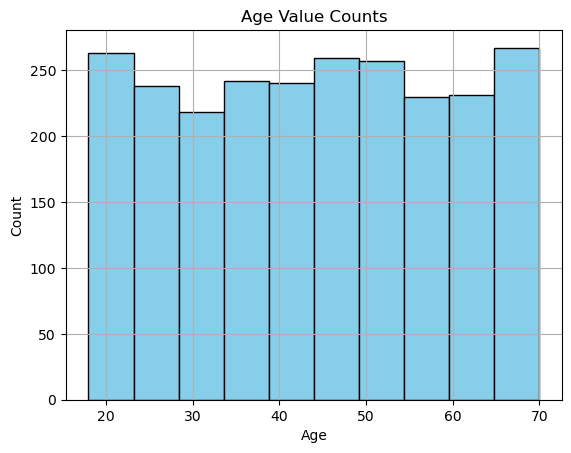

In [62]:
consumer_df['Age'].hist(bins=10, color='skyblue', edgecolor='black')
plt.title('Age Value Counts')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

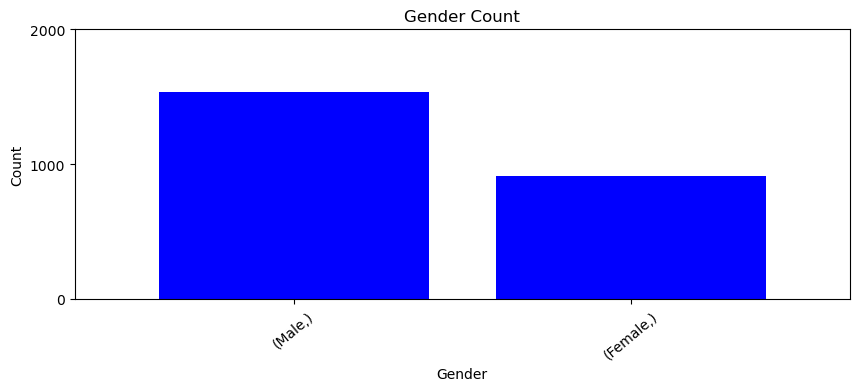

In [63]:
gender_df = consumer_data_df[["Gender"]]

gender_count = gender_df.value_counts()

fav_genre_chart = gender_count.plot.bar(y='Count', rot=40, width=0.8, figsize=(10,3.5), ylim=(0,2000),
                                    title='Gender Count',
                                    yticks=[0,1000,2000], xlabel='Gender', ylabel='Count', color='blue')

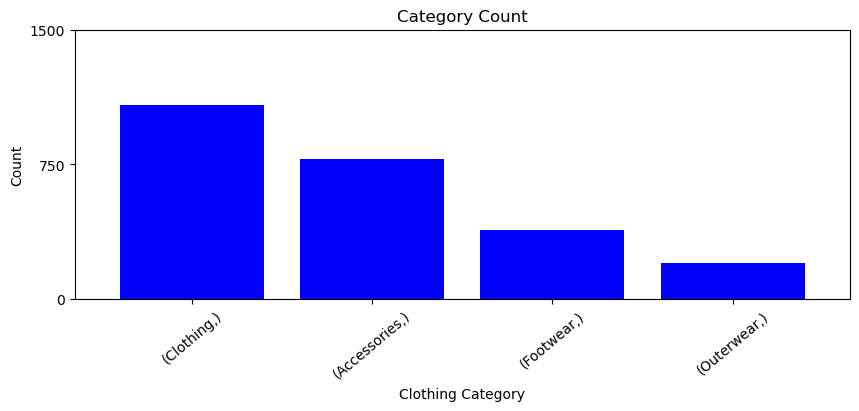

In [64]:
category_df = consumer_data_df[["Category"]]

category_count = category_df.value_counts()

fav_genre_chart = category_count.plot.bar(y='Category', rot=40, width=0.8, figsize=(10,3.5), ylim=(0,1500),
                                    title='Category Count',
                                    yticks=[0,750,1500], xlabel='Clothing Category', ylabel='Count', color='blue')

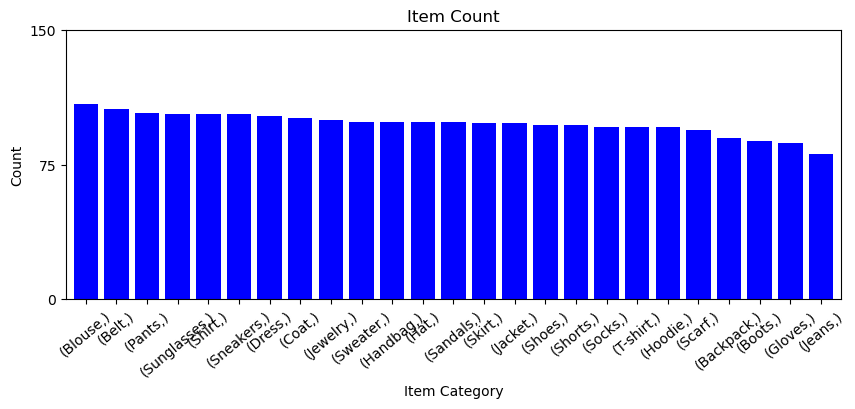

In [65]:
item_df = consumer_data_df[["Item_Purchased"]]

item_count = item_df.value_counts()

fav_genre_chart = item_count.plot.bar(y='Item', rot=40, width=0.8, figsize=(10,3.5), ylim=(0,150),
                                    title='Item Count',
                                    yticks=[0,75,150], xlabel='Item Category', ylabel='Count', color='blue')

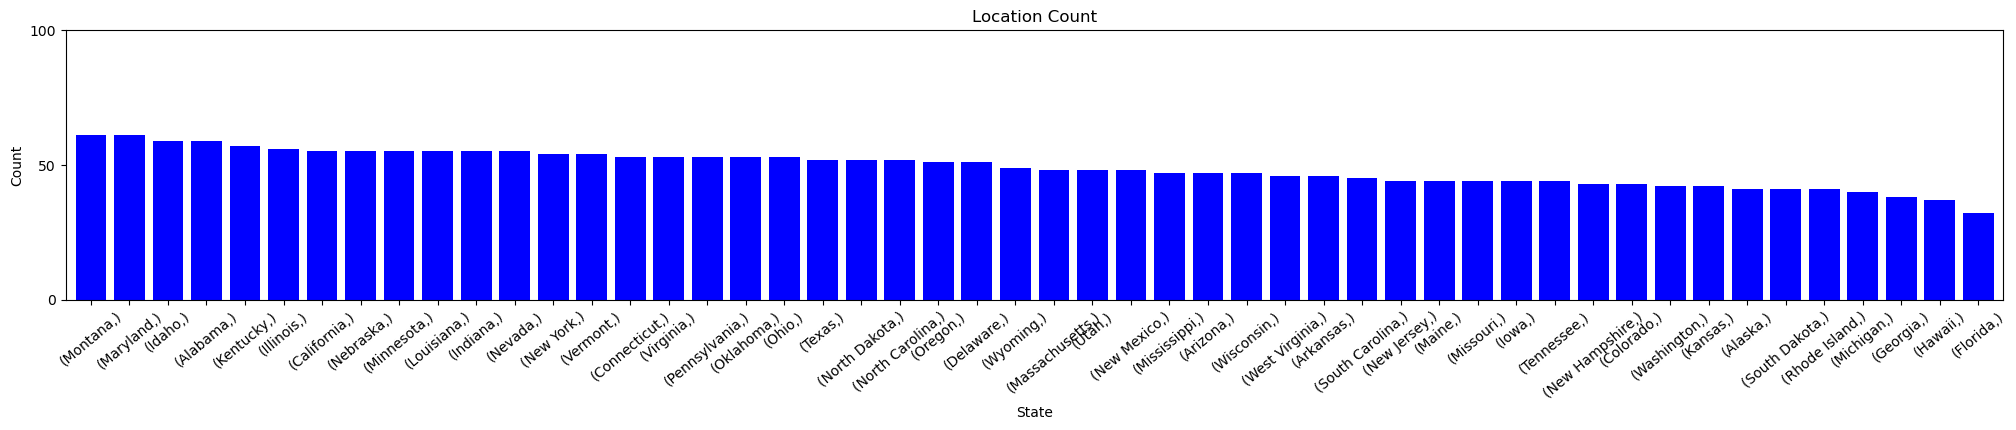

In [66]:
location_df = consumer_data_df[["Location"]]

location_count = location_df.value_counts()

fav_genre_chart = location_count.plot.bar(y='Location', rot=40, width=0.8, figsize=(25,3.5), ylim=(0,100),
                                    title='Location Count',
                                    yticks=[0,50,100], xlabel='State', ylabel='Count', color='blue')

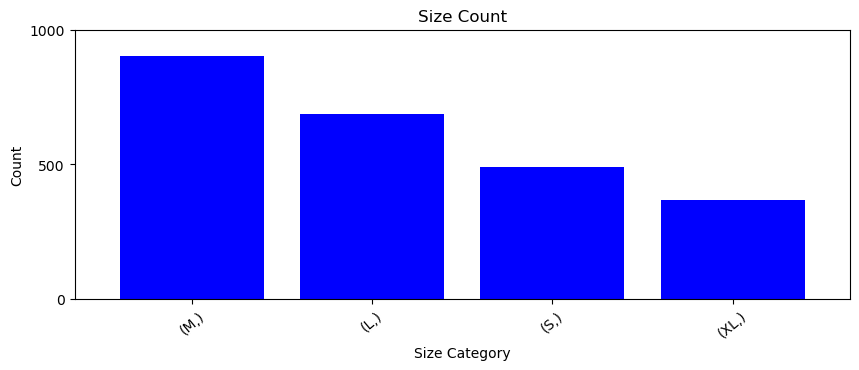

In [67]:
size_df = consumer_data_df[["Size"]]

size_count = size_df.value_counts()

fav_genre_chart = size_count.plot.bar(y='Size', rot=40, width=0.8, figsize=(10,3.5), ylim=(0,1000),
                                    title='Size Count',
                                    yticks=[0,500,1000], xlabel='Size Category', ylabel='Count', color='blue')

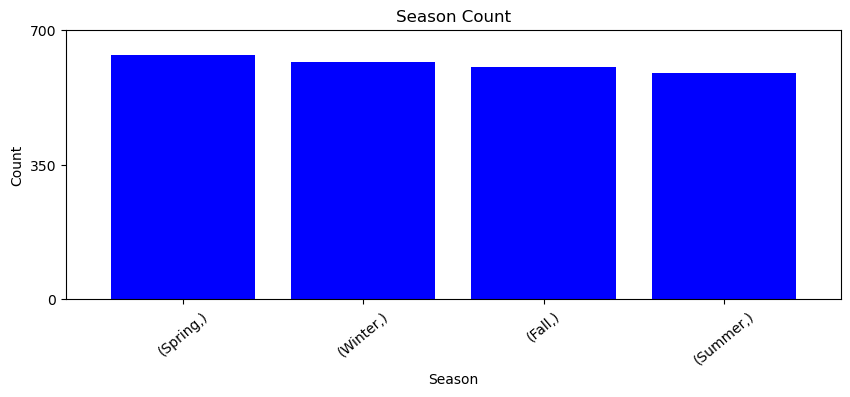

In [68]:
season_df = consumer_data_df[["Season"]]

season_count = season_df.value_counts()

fav_genre_chart = season_count.plot.bar(y='Season', rot=40, width=0.8, figsize=(10,3.5), ylim=(0,700),
                                    title='Season Count',
                                    yticks=[0,350,700], xlabel='Season', ylabel='Count', color='blue')

### Standard Scaler - Prepare the Data

In [92]:
#Create DataFrame for Standard Scaler
consumer_df_SS = consumer_df.copy()
consumer_df_SS = consumer_df_SS.drop(columns=['Customer_ID','Category_ID', 'Item_Purchased_ID', 'Location', 'Size', 'Color','Sku_ID', 'Season','Shipping_Type','Discount_Applied','Frequency of Purchases'])
consumer_df_SS.head()

,Age,Gender,Category,Item_Purchased,Purchase_Amount (USD),Review_Rating,Subscription Status,Previous_Purchases
0,55,1,Clothing,Blouse,53,3.1,1,14
1,19,1,Clothing,Sweater,64,3.1,1,2
2,50,1,Clothing,Jeans,73,3.1,1,23
3,21,1,Footwear,Sandals,90,3.5,1,49
4,45,1,Clothing,Blouse,49,2.7,1,31


In [70]:
# Use the StandardScaler module and fit_transform function to 
# scale all columns with numerical values
rate_df_scaled = StandardScaler().fit_transform(consumer_df_SS[["Age", "Gender", "Purchase_Amount (USD)","Review_Rating","Subscription Status","Previous_Purchases"]])

# Diplay the first five rows of the scaled data
rate_df_scaled[0:5]

array([[ 0.71729538, -0.76995706, -0.2923183 , -0.91670065, -1.39364209,
        -0.78043318],
       [-1.65527008, -0.76995706,  0.17376545, -0.91670065, -1.39364209,
        -1.6106692 ],
       [ 0.3877724 , -0.76995706,  0.5551067 , -0.91670065, -1.39364209,
        -0.15775616],
       [-1.52346088, -0.76995706,  1.27541796, -0.35454036, -1.39364209,
         1.64108855],
       [ 0.05824942, -0.76995706, -0.4618033 , -1.47886094, -1.39364209,
         0.39573452]])

In [91]:
# Create a DataFrame called with the scaled data
# The column names should match those referenced in the StandardScaler step
rate_df_scaled = pd.DataFrame(
    rate_df_scaled,
    columns=["Age", "Gender", "Purchase_Amount (USD)","Review_Rating","Subscription Status","Previous_Purchases"])
rate_df_scaled

,Age,Gender,Purchase_Amount (USD),Review_Rating,Subscription Status,Previous_Purchases
0,0.717295,-0.769957,-0.292318,-0.916701,-1.393642,-0.780433
1,-1.655270,-0.769957,0.173765,-0.916701,-1.393642,-1.610669
2,0.387772,-0.769957,0.555107,-0.916701,-1.393642,-0.157756
3,-1.523461,-0.769957,1.275418,-0.354540,-1.393642,1.641089
4,0.058249,-0.769957,-0.461803,-1.478861,-1.393642,0.395735
...,...,...,...,...,...,...
2440,-0.271274,1.298774,-1.351600,0.629240,0.717544,0.464921
2441,0.519582,1.298774,-0.461803,1.050860,0.717544,1.087598
2442,0.124154,1.298774,-1.139743,-1.197781,0.717544,-0.088570
2443,-0.007655,1.298774,0.724592,0.067080,0.717544,-0.088570


In [94]:
# Encode (convert to dummy variables) the "Item_Purchased" column
item_encoded = pd.get_dummies(consumer_df_SS['Item_Purchased'])

# Review the DataFrame
item_encoded.head()

,Backpack,Belt,Blouse,Boots,Coat,Dress,Gloves,Handbag,Hat,Hoodie,...,Scarf,Shirt,Shoes,Shorts,Skirt,Sneakers,Socks,Sunglasses,Sweater,T-shirt
0,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [95]:
# Encode (convert to dummy variables) the "Category" column
category_encoded = pd.get_dummies(consumer_df_SS['Category'])

# Review the DataFrame
category_encoded.head()

,Accessories,Clothing,Footwear,Outerwear
0,False,True,False,False
1,False,True,False,False
2,False,True,False,False
3,False,False,True,False
4,False,True,False,False


In [96]:
# Concatenate the scaled data DataFrame with the "Category" and "Item_Category" encoded dummies 
rate_df_scaled = pd.concat([rate_df_scaled, category_encoded, item_encoded], axis=1)

# Display the combined DataFrame.
rate_df_scaled.head()

,Age,Gender,Purchase_Amount (USD),Review_Rating,Subscription Status,Previous_Purchases,Accessories,Clothing,Footwear,Outerwear,...,Scarf,Shirt,Shoes,Shorts,Skirt,Sneakers,Socks,Sunglasses,Sweater,T-shirt
0,0.717295,-0.769957,-0.292318,-0.916701,-1.393642,-0.780433,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,-1.655270,-0.769957,0.173765,-0.916701,-1.393642,-1.610669,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
2,0.387772,-0.769957,0.555107,-0.916701,-1.393642,-0.157756,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,-1.523461,-0.769957,1.275418,-0.354540,-1.393642,1.641089,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,0.058249,-0.769957,-0.461803,-1.478861,-1.393642,0.395735,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


### Fit and Predict with KMeans

In [71]:
consumer_df_kmeans = consumer_df.copy()
consumer_df_kmeans = consumer_df_kmeans.drop(columns=['Customer_ID', 'Category','Category_ID', 'Item_Purchased', 'Item_Purchased_ID', 'Location', 'Size', 'Color','Sku_ID', 'Season','Shipping_Type','Discount_Applied','Frequency of Purchases'])
consumer_df_kmeans.head()

,Age,Gender,Purchase_Amount (USD),Review_Rating,Subscription Status,Previous_Purchases
0,55,1,53,3.1,1,14
1,19,1,64,3.1,1,2
2,50,1,73,3.1,1,23
3,21,1,90,3.5,1,49
4,45,1,49,2.7,1,31


### Train the K-means algorithm where k=2

In [72]:
# Initialize the K-Means model; n_clusters=2 and n_init='auto'
model_k2 = KMeans(n_clusters=4, n_init='auto')

In [73]:
# Fit the model
model_k2.fit(consumer_df_kmeans)

KMeans(n_clusters=4)

In [74]:
# Predict the model segments (clusters)
customer_segments_k2 = model_k2.predict(consumer_df_kmeans)

# View the customer segments
print(customer_segments_k2)

[2 3 3 ... 2 3 1]


### Train the K-means algorithm where k=3

In [75]:
# Initialize the K-Means model; n_clusters=3 and n_init='auto'
model_k3 = KMeans(n_clusters=3, n_init='auto')

In [76]:
# Fit the model
model_k3.fit(consumer_df_kmeans)

KMeans(n_clusters=3)

In [77]:
# Predict the model segments (clusters)
customer_segments_k3 = model_k3.predict(consumer_df_kmeans)

# View the customer segments
print(customer_segments_k3)

[2 0 0 ... 2 0 0]


In [78]:
# Create a copy of the original DataFrame and name it as customer_predictions
customer_predictions = consumer_df_kmeans.copy()

In [79]:
# Create a new column in the DataFrame with the predicted clusters with k=2
customer_predictions["Customer Segment (k=2)"] = customer_segments_k2

In [80]:
# Create a new column in the DataFrame with the predicted clusters with k=3
customer_predictions["Customer Segment (k=3)"] = customer_segments_k3

In [81]:
# Review the DataFrame
customer_predictions.head()

,Age,Gender,Purchase_Amount (USD),Review_Rating,Subscription Status,Previous_Purchases,Customer Segment (k=2),Customer Segment (k=3)
0,55,1,53,3.1,1,14,2,2
1,19,1,64,3.1,1,2,3,0
2,50,1,73,3.1,1,23,3,0
3,21,1,90,3.5,1,49,1,1
4,45,1,49,2.7,1,31,2,2


<Axes: title={'center': 'Scatter Plot by Shopping Segment - k=2'}, xlabel='Age', ylabel='Purchase_Amount (USD)'>

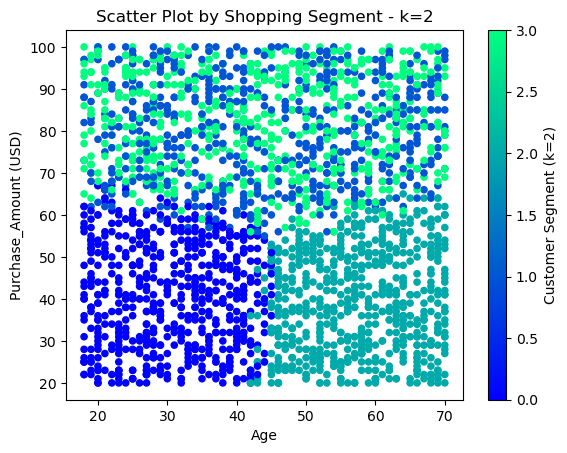

In [82]:
# Create a scatter plot with x="Frozen" and y="Grocery" with k=2 segments
customer_predictions.plot.scatter(
    x="Age", 
    y="Purchase_Amount (USD)", 
    c="Customer Segment (k=2)",
    title = "Scatter Plot by Shopping Segment - k=2",
    colormap='winter'
)

<Axes: title={'center': 'Scatter Plot by Shopping Segment - k=3'}, xlabel='Age', ylabel='Purchase_Amount (USD)'>

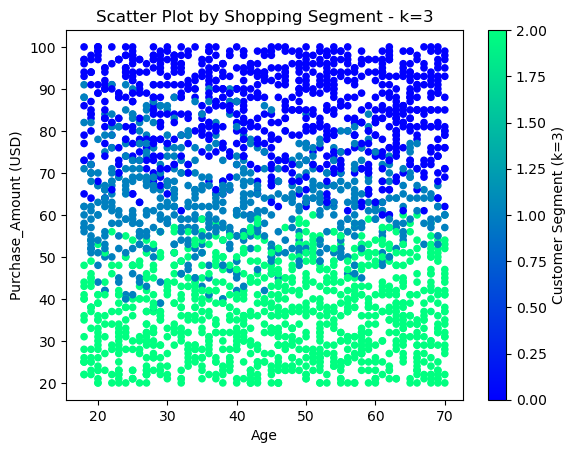

In [83]:
# Create a scatter plot with x="Frozen" and y="Grocery" with k=2 segments
customer_predictions.plot.scatter(
    x="Age", 
    y="Purchase_Amount (USD)", 
    c="Customer Segment (k=3)",
    title = "Scatter Plot by Shopping Segment - k=3",
    colormap='winter'
)

In [84]:
# Create an empty list to store the inertia values
inertia = []

# Create a list with the number of k-values to try
k = list(range(1, 11))

In [85]:
# Create a for loop to compute the inertia with each possible value of k and add the values to the inertia list.
for i in k:
    model = KMeans(n_clusters=i, n_init='auto', random_state=1)
    model.fit(consumer_df_kmeans)
    inertia.append(model.inertia_)

In [86]:
# Create a dictionary with the data to plot the elbow curve
elbow_data = {
    "k": k,
    "inertia": inertia
}

# Create a DataFrame with the data to plot the elbow curve
df_elbow = pd.DataFrame(elbow_data)

# Display the DataFrame
df_elbow

,k,inertia
0,1,2.437936e+06
1,2,1.412116e+06
2,3,1.207955e+06
3,4,9.958634e+05
4,5,8.623530e+05
5,6,7.525343e+05
6,7,6.819237e+05
7,8,6.030965e+05
8,9,5.442495e+05
9,10,4.928681e+05


Percentage decrease from k=1 to k=2: 42.08%
Percentage decrease from k=2 to k=3: 14.46%
Percentage decrease from k=3 to k=4: 17.56%
Percentage decrease from k=4 to k=5: 13.41%
Percentage decrease from k=5 to k=6: 12.73%
Percentage decrease from k=6 to k=7: 9.38%
Percentage decrease from k=7 to k=8: 11.56%
Percentage decrease from k=8 to k=9: 9.76%
Percentage decrease from k=9 to k=10: 9.44%


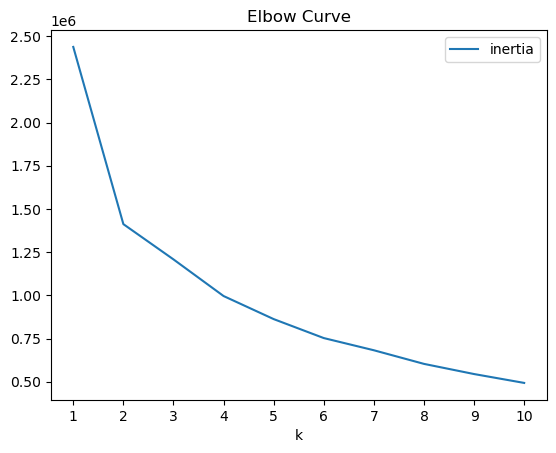

In [87]:
# Plot the Elbow curve
df_elbow.plot.line(x="k",
                   y="inertia",
                   title="Elbow Curve",
                   xticks=k)

# Determine the rate of decrease between each k value. 
k = elbow_data["k"]
inertia = elbow_data["inertia"]
for i in range(1, len(k)):
    percentage_decrease = (inertia[i-1] - inertia[i]) / inertia[i-1] * 100
    print(f"Percentage decrease from k={k[i-1]} to k={k[i]}: {percentage_decrease:.2f}%")

In [88]:
# Define the model with 3 clusters
model = KMeans(n_clusters=12, n_init='auto', random_state=1)

# Fit the model
model.fit(consumer_df_kmeans)

# Make predictions
k_3 = model.predict(consumer_df_kmeans)

# Create a copy of the DataFrame
customers_predictions_df = consumer_df_kmeans.copy()

# Add a class column with the labels
customers_predictions_df['customer_segment'] = k_3


In [89]:
# Review the DataFrame
customers_predictions_df

,Age,Gender,Purchase_Amount (USD),Review_Rating,Subscription Status,Previous_Purchases,customer_segment
0,55,1,53,3.1,1,14,2
1,19,1,64,3.1,1,2,7
2,50,1,73,3.1,1,23,3
3,21,1,90,3.5,1,49,4
4,45,1,49,2.7,1,31,2
...,...,...,...,...,...,...,...
2440,40,2,28,4.2,2,32,8
2441,52,2,49,4.5,2,41,5
2442,46,2,33,2.9,2,24,0
2443,44,2,77,3.8,2,24,3


<Axes: title={'center': 'Scatter Plot by Shopping Segment - k=3'}, xlabel='Age', ylabel='Purchase_Amount (USD)'>

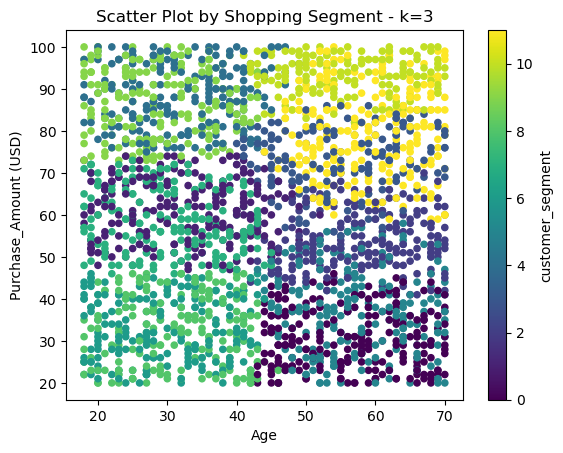

In [90]:
# Create a scatter plot with x="Frozen" and y="Grocery" with k=4 segments
customers_predictions_df.plot.scatter(
    x="Age", 
    y="Purchase_Amount (USD)", 
    c="customer_segment",
    title = "Scatter Plot by Shopping Segment - k=3",
    colormap='viridis'
)